In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.MEL_Gen import MEL_Gen, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 1488
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 300
list_drop = [
    "XC509721.ogg",
    "XC428067.ogg",
    "XC523831.ogg",
    "XC523960.ogg",
    "XC237870.ogg",
    "XC129924.ogg",
    "XC576851.ogg",
    "XC579430.ogg",
    "XC590621.ogg",
]

In [3]:
final = pd.read_csv("/app/_data/labels_nocall/nocall_predictions.csv")
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls.csv")

In [4]:
all_audio_init = pd.read_csv("/app/_data/all_audio_initial.csv")
all_audio = all_audio_init.query("filename not in @list_drop").reset_index(drop=True)
all_audio = all_audio.query("year >=1980 and year<=2021").reset_index(drop=True)

all_audio.shape

(65128, 24)

# dict_birds and weights

In [5]:
all_audio = all_audio[all_audio["rating"] >= 3]

In [6]:
dict_birds, all_audio = make_dict_birds(all_audio)

In [7]:
len(dict_birds)

398

In [8]:
# os.mkdir("/app/_data/models/from_nocall/Eff2_3/")

In [9]:
file_json = open("/app/_data/models/from_nocall/Eff2_3/dict_birds.json", "w")
json.dump(dict_birds, file_json)
file_json.close()

In [10]:
dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
# all_audio["class_weights"] = all_audio["class_weights"] * all_audio["rating"]

## calls

In [11]:
drop_list_final = final[(final["bird"] == 1) & (final["nocall"] == 1)][
    "row_id"
].tolist()

In [12]:
final = final.query("row_id not in @drop_list_final")
final = final.query("bird == 1")


In [13]:
final = final.merge(
    all_audio[["filename", "primary_label", "class_weights", 'duration']], on="filename", how="left"
)

In [14]:
final = final.dropna(axis=0)
final = final.drop(['nocall', 'bird'], axis=1)

In [15]:
final_0_20 = final[final['duration']<19]
final_20_30 = final[(final['duration']>=19)&(final['duration']<=30)]
final_30 = final[final['duration']>30]

In [16]:
final_20_30['duration'] = final_20_30['duration']-4
final_30['duration'] = final_30['duration']-7

In [17]:
final_20_30 = final_20_30[final_20_30['end_sec']<=final_20_30['duration']]
final_30 = final_30[final_30['end_sec']<=final_30['duration']]

In [18]:
final = pd.concat([final_0_20,final_20_30,final_30], axis=0, ignore_index=True)

In [19]:
final

,row_id,filename,end_sec,primary_label,class_weights,duration
0,XC11209_5_0,XC11209.ogg,5.0,acafly,0.008547,16.654156
1,XC11209_6_0,XC11209.ogg,6.0,acafly,0.008547,16.654156
2,XC11209_7_0,XC11209.ogg,7.0,acafly,0.008547,16.654156
3,XC11209_8_0,XC11209.ogg,8.0,acafly,0.008547,16.654156
4,XC11209_9_0,XC11209.ogg,9.0,acafly,0.008547,16.654156
...,...,...,...,...,...,...
2104838,XC615888_66_0,XC615888.ogg,66.0,yetvir,0.010870,70.125000
2104839,XC615888_67_0,XC615888.ogg,67.0,yetvir,0.010870,70.125000
2104840,XC615888_68_0,XC615888.ogg,68.0,yetvir,0.010870,70.125000
2104841,XC615888_69_0,XC615888.ogg,69.0,yetvir,0.010870,70.125000


In [20]:
dict_w = pd.DataFrame((1/final['filename'].value_counts()))
dict_w.columns=['weights']
dict_w['filename'] = dict_w.index

In [21]:
final = final.merge(dict_w, on='filename', how='left')

In [22]:
final_sample = final.sample(1000000, weights="weights", random_state=SEED)
final_sample = final_sample.sample(300000, weights="class_weights", random_state=SEED)

In [23]:
final_sample['primary_label'].value_counts()

normoc     1467
bulori     1381
yebcha     1333
cubthr     1321
bncfly     1275
           ... 
hofwoo1     117
crfpar      110
whcpar      109
stvhum2      42
wegspa1      41
Name: primary_label, Length: 397, dtype: int64

In [24]:
final_sample['filename'].value_counts()

XC285559.ogg    42
XC580707.ogg    40
XC320750.ogg    39
XC153986.ogg    39
XC237855.ogg    38
                ..
XC559874.ogg     1
XC377325.ogg     1
XC56863.ogg      1
XC538463.ogg     1
XC184987.ogg     1
Name: filename, Length: 48702, dtype: int64

In [25]:
final_sample

,row_id,filename,end_sec,primary_label,class_weights,duration,weights
398202,XC559561_9_0,XC559561.ogg,9.0,bewwre,0.002475,34.183156,0.033333
209382,XC233974_13_0,XC233974.ogg,13.0,webwoo1,0.009709,21.170094,0.076923
2003003,XC329805_9_0,XC329805.ogg,9.0,whtspa,0.004831,136.989000,0.016393
2101563,XC332589_20_0,XC332589.ogg,20.0,yeteup1,0.025000,23.368437,0.052632
197569,XC257520_16_0,XC257520.ogg,16.0,sposan,0.012500,16.807625,0.083333
...,...,...,...,...,...,...,...
594085,XC316127_10_0,XC316127.ogg,10.0,burwar1,0.006536,63.381000,0.018868
1389042,XC149480_36_0,XC149480.ogg,36.0,oaktit,0.010101,78.549000,0.014493
1859986,XC582727_76_0,XC582727.ogg,76.0,tromoc,0.008772,106.653000,0.009804
1825203,XC243411_137_0,XC243411.ogg,137.0,tenwar,0.008264,142.557000,0.008264


In [26]:
final_sample = final_sample[
    ["row_id", "filename", "end_sec", "primary_label", "class_weights"]
].merge(
    all_audio[
        [
            "filename",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
        ]
    ],
    on="filename",
    how="left",
)

In [27]:
final_sample = final_sample.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [28]:
final_sample["primary_label"].value_counts()

normoc     1467
bulori     1381
yebcha     1333
cubthr     1321
bncfly     1275
           ... 
hofwoo1     117
crfpar      110
whcpar      109
stvhum2      42
wegspa1      41
Name: primary_label, Length: 397, dtype: int64

# nocall

In [29]:
nocall = nocall.drop_duplicates()

nocall["file_path"] = nocall["file_path"].str.replace("birdclef-2021/", "")

nocall = nocall[~nocall['file_path'].str.contains('train_soundscapes')].reset_index(drop=True)

soundscapes_nocall =all_audio[all_audio['file_path'].str.contains('train_soundscapes')]
soundscapes_nocall = soundscapes_nocall[soundscapes_nocall['primary_label']=='nocall']

dict_w = (1/nocall['filename'].value_counts()).to_dict()
nocall['weights'] = nocall['filename'].replace(dict_w)

nocall_sample = nocall.sample(1200, random_state=SEED,  weights='weights')

nocall_sample['filename'].value_counts()

XC327562.ogg    15
XC277582.ogg    13
XC293291.ogg    13
XC217733.ogg    12
XC256594.ogg    12
                ..
XC210768.ogg     1
XC291092.ogg     1
XC259210.ogg     1
XC132192.ogg     1
XC187408.ogg     1
Name: filename, Length: 192, dtype: int64

In [30]:
nocall_sample = nocall_sample.merge(
    all_audio[
        [
            "filename",
            "rating",
            "year",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            'class_weights'
        ]
    ],
    on="filename",
    how="left",
)

nocall_sample = nocall_sample[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]
soundscapes_nocall = soundscapes_nocall[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]

soundscapes_nocall['duration']=600

all_nocall = pd.concat([nocall_sample, soundscapes_nocall], axis=0, ignore_index=True)

all_nocall["label_id"] = dict_birds["nocall"]
all_nocall["secondary_labels_id"] = np.nan
all_nocall = all_nocall.sample(frac=1, random_state=SEED).reset_index(drop=True)

all_nocall.isna().sum()

all_nocall['year'].describe()

filename                  0
row_id                    0
start_sec                 0
end_sec                   0
file_path                 0
duration                  0
rating                    0
year                      0
sin_month                 0
cos_month                 0
sin_longitude             0
cos_longitude             0
latitude                  0
norm_latitude             0
class_weights             0
label_id                  0
secondary_labels_id    2729
dtype: int64

count    2729.000000
mean     2015.901063
std         4.798173
min      1989.000000
25%      2015.000000
50%      2017.000000
75%      2019.000000
max      2021.000000
Name: year, dtype: float64

# concat

In [31]:
final_audio = (
    pd.concat(
        [final_sample, all_nocall],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

(302729, 19)

In [32]:
final_audio["primary_label"].value_counts().tail(20)

lotduc     377
amewig     358
flrtan1    342
sander     338
nrwswa     332
goowoo1    328
rebsap     318
higmot1    306
grhcha1    253
bucmot2    220
rthhum     218
rehbar1    206
gretin1    179
heptan     168
runwre1    152
hofwoo1    117
crfpar     110
whcpar     109
stvhum2     42
wegspa1     41
Name: primary_label, dtype: int64

#  upsampling


In [33]:
rare_birds = list(final_audio["primary_label"].value_counts().tail(20).index.values)

In [34]:
df = pd.DataFrame(columns=["end_sec", "class_weights", "filename"])
for bird in rare_birds:
    rare_bird_filenames = (
    all_audio.query("primary_label ==@bird")["filename"].unique().tolist())
    rare_array = all_audio.query(
        "primary_label ==@bird and rating!=0 and rating!=6 and filename in @rare_bird_filenames"
    )[["filename", "duration", "class_weights"]].values
    intervals = make_intervals_upsampling(rare_array,sum_intervals=600)
    df = pd.concat([df, intervals], axis=0)

df

,end_sec,class_weights,filename
XC113503_5_0,5.00,0.018182,XC113503.ogg
XC113503_7_62,7.62,0.018182,XC113503.ogg
XC113503_10_24,10.24,0.018182,XC113503.ogg
XC113503_12_85,12.85,0.018182,XC113503.ogg
XC113503_15_48,15.48,0.018182,XC113503.ogg
...,...,...,...
XC433788_36_58,36.58,0.200000,XC433788.ogg
XC433788_36_71,36.71,0.200000,XC433788.ogg
XC433788_36_84,36.84,0.200000,XC433788.ogg
XC433788_36_97,36.97,0.200000,XC433788.ogg


In [35]:
df['filename'].unique().shape

(545,)

In [36]:
df["row_id"] = df.index
df = df.merge(
    all_audio[
        [
            "filename",
            "primary_label",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "frames",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "date",
        ]
    ],
    on="filename",
    how="left",
)
df["end_sec"] = df["end_sec"].apply(lambda x: x if x > 5 else 5)
df["start_sec"] = df["end_sec"] - 5

In [37]:
df['primary_label'].unique().shape

(20,)

In [38]:
final_audio = (
    pd.concat(
        [final_audio, df],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

final_audio["primary_label"].value_counts().tail(20)

(316144, 21)

whimbr     450
rudtur     448
rufhum     447
rucwar     434
pavpig2    421
semplo     419
comgol     416
scamac1    413
greegr     407
grnher     401
scrtan1    399
leasan     398
blctan1    398
commer     397
norsho     397
sthwoo1    394
cacgoo1    387
wooduc     383
brwpar1    381
buwtea     378
Name: primary_label, dtype: int64

In [39]:
train, valid = train_test_split(final_audio, train_size=0.8, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# MEL_Gen

In [40]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 224

In [41]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [42]:
# shutil.rmtree('/app/_data/npy/short_mels_224_uint8/', ignore_errors=True)

In [43]:
gen_train = MEL_Gen(
    df=train,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=True,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
    secondary_coeff=0.3
)
gen_valid = MEL_Gen(
    df=valid,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
    secondary_coeff=0.3
)

In [44]:
a = gen_train.__getitem__(0)

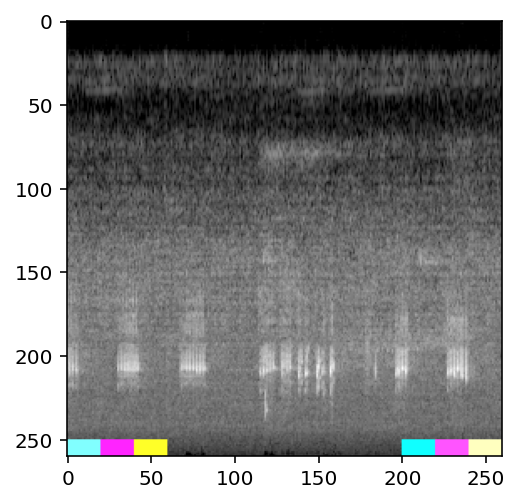

In [45]:
plt.imshow(a[0][0])

# model

In [46]:
def get_model():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = keras.applications.EfficientNetB2(
        weights="imagenet", include_top=False
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
        ],
    )
    return model


policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [47]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="min",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/from_nocall/Eff2_3/Eff2_3.h5",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="min",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(
        log_dir="/app/.tensorboard/Eff2_3_nc/", histogram_freq=0
    ),
    keras.callbacks.experimental.BackupAndRestore(
        "/app/_data/models/from_nocall/Eff2_3/backup/"
    ),
    keras.callbacks.TerminateOnNaN(),
]

In [48]:
model = get_model()
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE,
    validation_steps=valid.shape[0] // BATCH_SIZE,
    verbose=1,
    workers=20,
    max_queue_size=50,
    callbacks=callbacks,
)

Epoch 1/100
   1/1129 [..............................] - ETA: 5s - loss: 0.7065 - acc: 0.0000e+00 - recall: 0.4889 - precision: 0.0050 - f1_score: 0.0023WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1129/1129 [==============================] - ETA: 0s - loss: 0.0221 - acc: 0.1436 - recall: 0.0173 - precision: 0.0608 - f1_score: 0.1357
Epoch 00001: val_loss improved from inf to 0.01316, saving model to /app/_data/models/from_nocall/Eff2_3/Eff2_3.h5
1129/1129 [==============================] - 1409s 1s/step - loss: 0.0221 - acc: 0.1436 - recall: 0.0173 - precision: 0.0608 - f1_score: 0.1357 - val_loss: 0.0132 - val_acc: 0.4396 - val_recall: 0.1599 - val_precision: 0.6941 - val_f1_score: 0.3925
Epoch 2/100
1129/1129 [==============================] - ETA: 0s - 

ResourceExhaustedError:  OOM when allocating tensor with shape[224,131,131,96] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/functional_1/efficientnetb2/block2a_dwconv/depthwise/DepthwiseConv2dNativeBackpropInput (defined at <ipython-input-48-2f01e9ec22f2>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_40510]

Function call stack:
train_function
